Este dataset busca encontrar o preço de um carro dada algumas variáveis, Será utilizado uma regressão usando o algoritmo KNN

In [140]:
#imports basicos
import pandas as pd
import numpy as np
import plotly.express as px

#analise exploratoria
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

#preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.base import TransformerMixin, BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

#KNN
from sklearn.neighbors import KNeighborsRegressor
from scipy.spatial.distance import mahalanobis

#avaliação do modelo
from sklearn.metrics import r2_score

#métodos de avaliação avançados
from sklearn.model_selection import GridSearchCV, StratifiedKFold


## IMPORTANDO O ARQUIVO

In [75]:
car = pd.read_csv(r'Car details v3.csv')
car.head()

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner     mileage   engine   max_power  \
0  Individual       Manual   First Owner   23.4 kmpl  1248 CC      74 bhp   
1  Individual       Manual  Second Owner  21.14 kmpl  1498 CC  103.52 bhp   
2  Individual       Manual   Third Owner   17.7 kmpl  1497 CC      78 bhp   
3  Individual       Manual   First Owner   23.0 kmpl  1396 CC      90 bhp   
4  Individual       Manual   First Owner   16.1 kmpl  1298 CC    88.2 bhp   

                     torque  seats  
0            190Nm@ 2000rpm    5.0  
1       250Nm@ 1500-2500rpm    5.0  
2     12.7@ 2,700(kgm@ rpm)    5.0  
3  22.4 kgm at 1750-2750rpm    5.0  
4     11.5@ 4,500(kgm@ rpm)    5.0

## VERIFICAÇÃO INICIAL DOS DADOS

In [76]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [77]:
car.describe()

year  selling_price     km_driven        seats
count  8128.000000   8.128000e+03  8.128000e+03  7907.000000
mean   2013.804011   6.382718e+05  6.981951e+04     5.416719
std       4.044249   8.062534e+05  5.655055e+04     0.959588
min    1983.000000   2.999900e+04  1.000000e+00     2.000000
25%    2011.000000   2.549990e+05  3.500000e+04     5.000000
50%    2015.000000   4.500000e+05  6.000000e+04     5.000000
75%    2017.000000   6.750000e+05  9.800000e+04     5.000000
max    2020.000000   1.000000e+07  2.360457e+06    14.000000

## TRATAMENTO INICIAL

Primeiramente vamos tirar as unidades das colunas mileage, engine e max_power, e colocar as unidades no nome das colunas 

In [78]:
#função para remover o sufixo
def remove_suffix(value):
    if isinstance(value, str) and value.strip():
        value = value.split(" ")[0]
        try:
            return float(value)
        except ValueError:
            try:
                return int(value)
            except ValueError:
                return 0      
    else:
        return 0

In [79]:
col = ['mileage', 'engine', 'max_power']
car[col] = car[col].applymap(remove_suffix)

In [80]:
car.rename(columns={"mileage": "mileage (kmpl)", "engine": "engine (CC)", "max_power": "max_power (bhp)"}, inplace=True)

In [81]:
car.head()

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner  mileage (kmpl)  engine (CC)  \
0  Individual       Manual   First Owner           23.40       1248.0   
1  Individual       Manual  Second Owner           21.14       1498.0   
2  Individual       Manual   Third Owner           17.70       1497.0   
3  Individual       Manual   First Owner           23.00       1396.0   
4  Individual       Manual   First Owner           16.10       1298.0   

   max_power (bhp)                    torque  seats  
0            74.00            190Nm@ 2000rpm    5.0  
1           103.52       250Nm@ 1500-2500rpm    5.0  
2            78.00     12.7@ 2,700(kgm@ rpm)    5.0  
3            90.00  22.4 kgm at 1750-2750rpm    5.0  
4            88.20     11.5@ 4,500(kgm@ rpm)    5.0

A coluna torque podemos remover pois não precisamos para nossa análises

In [82]:
car = car.drop(["torque"], axis=1)

In [83]:
car.head()

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner  mileage (kmpl)  engine (CC)  \
0  Individual       Manual   First Owner           23.40       1248.0   
1  Individual       Manual  Second Owner           21.14       1498.0   
2  Individual       Manual   Third Owner           17.70       1497.0   
3  Individual       Manual   First Owner           23.00       1396.0   
4  Individual       Manual   First Owner           16.10       1298.0   

   max_power (bhp)  seats  
0            74.00    5.0  
1           103.52    5.0  
2            78.00    5.0  
3            90.00    5.0  
4            88.20    5.0

## ANÁLISE EXPLORATÓRIA

1 - Ser o primeiro, segundo ou terceiro dono influencia no preço do carro? E o tipo de marcha? E o tipo de vendedor? E o combustivel?

In [84]:
#calculando preço médio de venda
mean_selling_price_by_owner = car.groupby('owner')['selling_price'].mean()
mean_selling_price_by_transmission = car.groupby('transmission')['selling_price'].mean()
mean_selling_price_by_seller_type = car.groupby('seller_type')['selling_price'].mean()
mean_selling_price_by_fuel = car.groupby('fuel')['selling_price'].mean()

# fazer um barplot sendo media do preço x numero de donos, tipo de marcha, tipo de vendedor e combustivel
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Bar(x=mean_selling_price_by_owner.index, y=mean_selling_price_by_owner.values, name='Preço médio de venda',  marker_color='blue', showlegend=False), row=1, col=1)
fig.add_trace(go.Bar(x=mean_selling_price_by_transmission.index, y=mean_selling_price_by_transmission.values, name='Preço médio de venda',  marker_color='green', showlegend=False), row=1, col=2)
fig.add_trace(go.Bar(x=mean_selling_price_by_seller_type.index, y=mean_selling_price_by_seller_type.values, name='Preço médio de venda',  marker_color='red', showlegend=False), row=2, col=1)
fig.add_trace(go.Bar(x=mean_selling_price_by_fuel.index, y=mean_selling_price_by_fuel.values, name='Preço médio de venda',  marker_color='orange', showlegend=False), row=2, col=2)

#Dando update no layout do subplot
fig.update_layout(title_text="Investigação do preço dos carros", height=600, width=800, barmode='group',
                  title_x=0.5, yaxis_title="Mean Selling Price")

#Ordenando os dados e a escala de cor para cada grafico
def sort_and_set_colors(trace, color_scale):
    sorted_idx = trace.y.argsort()[::-1]  # Reverse the order
    trace.x = trace.x[sorted_idx]
    trace.y = trace.y[sorted_idx]
    trace.marker.color = trace.y
    trace.marker.colorscale = color_scale

sort_and_set_colors(fig.data[0], 'RdBu')
sort_and_set_colors(fig.data[1], 'Jet')
sort_and_set_colors(fig.data[2], 'Reds')
sort_and_set_colors(fig.data[3], 'Oranges')

fig.show()


Podemos ver que carros de test drive possuem um preço medio bem mais alto, sugerindo talvez que eles possam ter uma quilometragem menor? Será verificado mais abaixo. Carros com câmbio automático são mais caros devido a sua complexidade, e carros vendidos por revendedor possui um preço maior, pois além de haver sua comissão ele tenta um preço mais alto possível. E vemos também que carros a diesel são mais caros.

2 - Quantidade de km dirigidos influencia muito no preço do carro?

In [85]:
#fazer um scatterplot de preço x km dirigidos, podendo colocar cores sendo qtde de donos
fig = px.scatter(car, x="km_driven", y="selling_price", color="owner")
fig.show()

Podemos observar que quanto mais quilômetros rodados menor o preço do carro, informação que já esperávamos.

3 - E o quanto a idade do carro influencia?

In [86]:
#scatterplot de preço x ano
mean_selling_price_by_year = car.groupby('year')['selling_price'].mean().reset_index()
fig = px.bar(mean_selling_price_by_year, x="year", y="selling_price")

fig.show()

Podemos ver que quanto mais novo o carro maior a tendência dele possuir um preço maior. Um preço maior em 1983 pode-se traduzir por pessoas que gostam de carros antigos e estão dispostas a pagar um pouco mais. E a tendência de 202 merece ser mais investigada.

4 - Qual distribuição dos preços dos carros?

In [87]:
#histplot dos preços dos carros
#filtrando os valores muito altos para o gráfico ficar de melhor visualização
filtered_car = car.query('selling_price < 4000000')

#calculando o histograma manualmente
hist, edges = np.histogram(filtered_car['selling_price'], bins=80)
max_bin_index = np.argmax(hist)

fig = go.Figure(data=[go.Bar(x=edges, y=hist, marker=dict(color='blue'))])

colors = ['red' if i == max_bin_index else 'blue' for i in range(len(hist))]
fig.data[0].marker.color = colors

fig.show()

Podemos ver que a maior parte dos carros custa entre 250 e 300 mil.

5 - Carros a gasolina ou a diesel gastam mais?

In [88]:
#barplot da media de consumo de combustivel por tipo de combustivel
mean_fuel_comsumption = car.groupby('fuel')['mileage (kmpl)'].mean().reset_index()
fig = px.bar(mean_fuel_comsumption, x="fuel", y="mileage (kmpl)", text_auto=True)

fig.show()

Podemos ver que carros com CNG possuem maior quilometragem, enquanto LPG possuem a menor.

6 - Relação a quantidade de donos e quilometragem do carro

## SPLIT DOS DADOS

Primeiramente vamos selecionar as colunas que irão para o modelo final e fazer o split dos dados

In [89]:
car.head()

name  year  selling_price  km_driven    fuel  \
0        Maruti Swift Dzire VDI  2014         450000     145500  Diesel   
1  Skoda Rapid 1.5 TDI Ambition  2014         370000     120000  Diesel   
2      Honda City 2017-2020 EXi  2006         158000     140000  Petrol   
3     Hyundai i20 Sportz Diesel  2010         225000     127000  Diesel   
4        Maruti Swift VXI BSIII  2007         130000     120000  Petrol   

  seller_type transmission         owner  mileage (kmpl)  engine (CC)  \
0  Individual       Manual   First Owner           23.40       1248.0   
1  Individual       Manual  Second Owner           21.14       1498.0   
2  Individual       Manual   Third Owner           17.70       1497.0   
3  Individual       Manual   First Owner           23.00       1396.0   
4  Individual       Manual   First Owner           16.10       1298.0   

   max_power (bhp)  seats  
0            74.00    5.0  
1           103.52    5.0  
2            78.00    5.0  
3            90.00    5.0  
4            88.20    5.0

In [90]:
car = car.drop('name', axis=1)

In [91]:
car.head()

year  selling_price  km_driven    fuel seller_type transmission  \
0  2014         450000     145500  Diesel  Individual       Manual   
1  2014         370000     120000  Diesel  Individual       Manual   
2  2006         158000     140000  Petrol  Individual       Manual   
3  2010         225000     127000  Diesel  Individual       Manual   
4  2007         130000     120000  Petrol  Individual       Manual   

          owner  mileage (kmpl)  engine (CC)  max_power (bhp)  seats  
0   First Owner           23.40       1248.0            74.00    5.0  
1  Second Owner           21.14       1498.0           103.52    5.0  
2   Third Owner           17.70       1497.0            78.00    5.0  
3   First Owner           23.00       1396.0            90.00    5.0  
4   First Owner           16.10       1298.0            88.20    5.0

In [92]:
car['seats'].fillna(0, inplace=True)

A coluna name não importa para nossa modelagem. Após isso vamos fazer o split dos dados, para posterior tratamento de forma a evitar data leakage:

In [93]:
#criando os dataframes X e y:
X = car.drop('selling_price', axis=1)
X.rename(columns={"transmission" : "manual_transmission"}, inplace=True)
y = car['selling_price']

In [94]:
X.shape

(8128, 10)

In [95]:
#para evitar problemas no imputer fazemos essa transformação aqui
X['seats'] = X['seats'].replace(['nan', 'N/A'], np.nan)

In [96]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 8128 non-null   int64  
 1   km_driven            8128 non-null   int64  
 2   fuel                 8128 non-null   object 
 3   seller_type          8128 non-null   object 
 4   manual_transmission  8128 non-null   object 
 5   owner                8128 non-null   object 
 6   mileage (kmpl)       8128 non-null   float64
 7   engine (CC)          8128 non-null   float64
 8   max_power (bhp)      8128 non-null   float64
 9   seats                8128 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 635.1+ KB


In [97]:
y.shape

(8128,)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

## FEATURE ENGINEERING

Primeiramente devemos tratar a coluna transmission de modo a ter apenas valores 0 e 1.

In [99]:
#transformer do genero
class TransmissionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['manual_transmission'] = X_transformed['manual_transmission'].map({'Manual': 1, 'Automatic': 0})
        
        # Handle missing values
        X_transformed['manual_transmission'] = X_transformed['manual_transmission'].fillna(-1)  # Replace NaN with a desired value
        
        return X_transformed

Para as outras variáveis categóricas devemos fazer one hot encoding. Porém isso vai aumentar demasiamente a dimensionalidade, o que requerirá algum processo de diminuição de dimensionalidade.

Após isso devemos verificar se não há valores nulos no dataset:

In [100]:
colunas = X.columns

for col in colunas:
    a = X[col].isnull().sum()
    print(f"Column: {col}, Null Count: {a}")

Column: year, Null Count: 0
Column: km_driven, Null Count: 0
Column: fuel, Null Count: 0
Column: seller_type, Null Count: 0
Column: manual_transmission, Null Count: 0
Column: owner, Null Count: 0
Column: mileage (kmpl), Null Count: 0
Column: engine (CC), Null Count: 0
Column: max_power (bhp), Null Count: 0
Column: seats, Null Count: 0


Agora precisamos fazer uma checagem e tratamento nos outliers, pois isso impactaria na performance do KNN

In [101]:
#criação dos thresholds para os outliers, coluna a coluna, no caso limite inferior são 5% dos dados e superior 95%
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [102]:
#checagem coluna a coluna quantos outliers existem caso existam
def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [103]:
#pegando apenas as colunas numéricas para checagem de outliers:
numeric_cols = X.drop(['fuel','seller_type','manual_transmission','owner'], axis=1)

In [104]:
for col in numeric_cols:
    print(col, f'-----There is outliers: {check_outlier(X, col, q1=0.05, q3=0.95)}')

year -----There is outliers: True
km_driven -----There is outliers: True
mileage (kmpl) -----There is outliers: False
engine (CC) -----There is outliers: False
max_power (bhp) -----There is outliers: True
seats -----There is outliers: True


In [105]:
#vamos plotar boxplots para inspecionar estes outliers:
fig = make_subplots(rows=1, cols=4)

fig.add_trace(go.Box(y=X['year'], name='Ano',  marker_color='indianred'), row=1, col=1)
fig.add_trace(go.Box(y=X['km_driven'], name='Km percorrido',  marker_color='lightseagreen'), row=1, col=2)
fig.add_trace(go.Box(y=X['max_power (bhp)'], name='Potência máxima',  marker_color='sienna'), row=1, col=3)
fig.add_trace(go.Box(y=X['seats'], name='Bancos',  marker_color='steelblue'), row=1, col=4)

#Dando update na figura para incluir os titulos no grafico
fig.update_layout(
    title_text="Box Plots",
    height=400,
    width=1000,
    title_x=0.5,
    yaxis_title="Value"
)

fig.show()

No caso acima, fizemos uma checagem de outliers e consideramos que tudo abaixo de 5% dos dados e tudo acima de 95% dos dados são outliers. Porém não removeremos os outliers de todas as variáveis, pois pode haver perda de informação, então será removido apenas os outliers dos km percorridos e a potência máxima.

agora será criado um transformer para remoção de outliers:

In [106]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, q1=0.05, q3=0.95):
        self.q1 = q1
        self.q3 = q3
        self.thresholds = {}
        self.outlier_indices_ = []

    def fit(self, X, y=None):
        self.outlier_indices_ = []  # Reset the outlier indices list
        for col in X.columns:
            low_limit, up_limit = outlier_thresholds(X, col, self.q1, self.q3)
            self.thresholds[col] = (low_limit, up_limit)
            outlier_indices = (X[col] < low_limit) | (X[col] > up_limit)
            self.outlier_indices_.extend(np.where(outlier_indices)[0])
        return self

    def transform(self, X):
        for col, (low_limit, up_limit) in self.thresholds.items():
            X[col] = X[col].clip(lower=low_limit, upper=up_limit)
        return X

    def outlier_indices_(self):
        return np.array(self.outlier_indices_)

Com isso temos o nosso column transformer para aplicar tanto nos dados de treino e teste:

In [107]:
preprocessor = ColumnTransformer(
    transformers=[
        ('Transformação da coluna transmissão', TransmissionTransformer(), ['manual_transmission']),
        ('One hot encoder', OneHotEncoder(), ['fuel','seller_type','owner']),
        ('remoçao de outliers', OutlierRemover(), ['km_driven','max_power (bhp)']),
        ('padronização', StandardScaler(), ['year','km_driven','mileage (kmpl)','engine (CC)','max_power (bhp)','seats'])
    ],
    remainder='passthrough'
)

agora iremos aplicar as transformações tanto nos dados de treino quanto de teste:

In [108]:
X_traint = preprocessor.fit_transform(X_train)

In [109]:
X_testt = preprocessor.fit_transform(X_test)

In [110]:
#resetando os indices dos dados de treino para evitar erros:
#Instanciando o OutlierRemover transformer
outlier_remover = OutlierRemover(q1=0.05, q3=0.95)

#Obtendo os indices dos outliers para remover de y também
outlier_indices = outlier_remover.outlier_indices_

#Removendo as linhas correspondentes de y_train
y_train_no_outliers = np.delete(y_train, outlier_indices, axis=0)

#fazendo o mesmo para y_test
y_test_no_outliers = np.delete(y_test, outlier_indices, axis=0)

In [111]:
X_traint.shape

(6096, 21)

In [112]:
y_train.shape

(6096,)

In [113]:
X_testt.shape

(2032, 21)

In [114]:
y_test.shape

(2032,)

In [115]:
pd.DataFrame(X_traint)

0    1    2    3    4    5    6    7    8    9   ...   11   12  \
0     1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0   
1     1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  ...  0.0  0.0   
2     1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...  0.0  0.0   
3     1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0   
4     1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
6091  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   
6092  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0   
6093  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0   
6094  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  ...  0.0  0.0   
6095  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   

            13     14        15        16        17        18        19  \
0     120000.0  80.84  1.042585  0.838713 -0.377300  2.240734 -0.217803   
1      67500.0  68.00 -0.451795 -0.043913 -1.324520  0.962551 -0.554313   
2      20000.0  75.00  1.291648 -0.842479  0.104204 -0.765363 -0.370857   
3     106000.0  65.00  0.046332  0.603346  0.372583  0.075834 -0.632937   
4     100000.0  75.00 -1.198985  0.502475 -0.219430 -0.311990 -0.370857   
...        ...    ...       ...       ...       ...       ...       ...   
6091   58245.0  73.90 -0.202732 -0.199507 -0.481888 -0.403029 -0.399686   
6092   10000.0  35.00 -0.700858 -1.010599  1.398738 -1.448153 -1.419177   
6093   48000.0  46.30 -0.949921 -0.371746  0.155512 -1.134980 -1.123027   
6094   36600.0  81.80  0.295395 -0.563401  0.293648 -0.404850 -0.192643   
6095   69779.0  81.80  1.042585 -0.005599  0.609388 -0.404850 -0.192643   

            20  
0     1.355816  
1     3.710532  
2    -0.213995  
3    -0.213995  
4    -0.213995  
...        ...  
6091 -0.213995  
6092 -0.998900  
6093 -0.213995  
6094 -0.213995  
6095 -0.213995  

[6096 rows x 21 columns]

Vemos que o modelo possui muitas variáveis agora depois do one hot encode. Portanto precisamos diminuir o número de dimensões antes de aplicar o KNN.

aplicar padronização no columntransformer

## MODELAGEM

In [116]:
#instanciando o modelo
knn = KNeighborsRegressor()

vamos fazer o cross validation para obter o valor ótimo de k

In [117]:
#obtendo os valores de k a testar
k = np.arange(26)
params = {'n_neighbors':k}

In [118]:
#fazendo cross validation com os valores de k:
modeloKNN = GridSearchCV(knn, params, cv=10, scoring='r2')

In [119]:
modeloKNN.fit(X_traint, y_train)
modeloKNN.best_params_

c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:427: FitFailedWarning:


10 fits failed out of a total of 260.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 734, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1141, in wrapper
    estimator._validate_params()
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.

{'n_neighbors': 2}

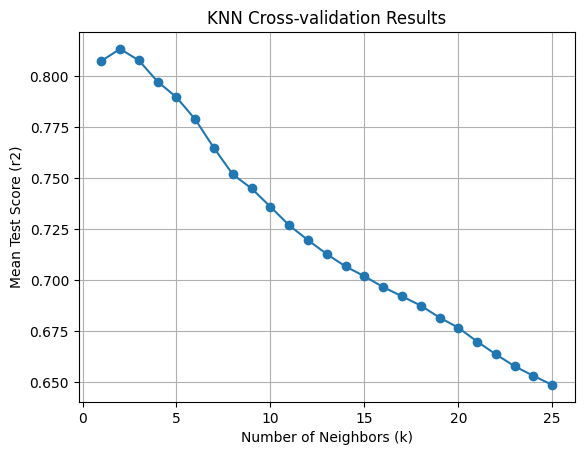

In [120]:
#Extraindo os resultados obtidos pelo cross validation
cv_results = modeloKNN.cv_results_

#Pegando os valores de k e seus scores de teste
k_values = cv_results['param_n_neighbors'].data.astype(int)
mean_test_scores = cv_results['mean_test_score']

#Plotando k versus seu score
plt.plot(k_values, mean_test_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Test Score (r2)')
plt.title('KNN Cross-validation Results')
plt.grid(True)
plt.show()

Agora precisamos reduzir a dimensionalidade do modelo para ver se temos uma melhora nos resultados, e para isso será usado o TruncatedSVD

In [134]:
#criando o TruncatedSVD transformer com o range de dimensões especificado
dimensoes = np.linspace(1, 22, 22).astype(int) 
svd_transformer = TruncatedSVD()

# criando o modelo KNN
knn_model = KNeighborsRegressor()

# Definindo o pipeline com o svd e knn
pipeline = Pipeline([
    ('svd', svd_transformer),
    ('knn', knn_model)
])

#definindo o parametro grid, o qual irá receber tudo o que querermos variar no knn
param_grid = {
    'svd__n_components': dimensoes,
    'knn__n_neighbors': np.arange(1, 26),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric':['minkowski', 'manhattan', 'euclidean','mahalanobis']
}

#criando o objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='r2'
)

#fit no gridcv
grid_search.fit(X_traint, y_train)

#Buscando os melhores parametros e os melhores scores
best_params = grid_search.best_params_
best_r2_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best r2 score:", best_r2_score)

c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:826: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 815, in _score
    scores = scorer(estimator, X_test, y_test)
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 351, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 84, in _cached_call
    r

Best parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance', 'svd__n_components': 7}
Best r2 score: 0.8451846648195618


c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:427: FitFailedWarning:


9500 fits failed out of a total of 44000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2000 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 734, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1148, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\alanv\AppData\Local\Programs\Python\Python310\lib\site

## AVALIAÇÃO DO MODELO

Vamos usar as métricas que encontramos no gridsearch para alimentar nosso modelo:

In [137]:
#Instanciando o modelo com os melhores parâmetros encontrados no gridsearch
best_svd_components = best_params['svd__n_components']
best_k_neighbors = best_params['knn__n_neighbors']
best_knn_weights = best_params['knn__weights']
best_knn_metrics = best_params['knn__metric']

svd_transformer = TruncatedSVD(n_components=best_svd_components)
knn_model = KNeighborsRegressor(n_neighbors=best_k_neighbors, weights=best_knn_weights, metric=best_knn_metrics)

In [138]:
#definindo um pipeline com svd e knn:
pipeline = Pipeline([
    ('svd', svd_transformer),
    ('knn', knn_model)
])

In [139]:
#fit do modelo e predições com dados de teste
pipeline.fit(X_traint, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_testt)

In [141]:

#Avaliando a performance do modelo:
r2_score_test = r2_score(y_test, y_pred)
print("Test R2 score:", r2_score_test)

Test R2 score: 0.8003811296136805


Obtivemos um R² de 80%, que é um bom valor para uma regressão